# Affordance Detector

**Please note that since the source code is under development, there may be changes in the performance**

In [2]:
# @title Download Files, Clone Git Repo, Move Files and import AffordanceAnalyzer Class
# @title Downloading Tensor Files and Required Libraries
!gdown 1-xut_M1T2hpTsGFcKoc8LGsSSVDrwske
!gdown 103CFnryrTUFSZFhmLL6-tP9ui5vPPU4-
!gdown 1-s_Kr3O7uP0KTL91Ss_V8Fyho6s6OWG6
!gdown 10rQgt720xNfqwaKkAZC8-DoHyqPVjHAQ
!gdown 10rsMnDM6LAd1DdOsuRAwoJ-oz8wasymL
!gdown 10mlW-u062prfC-R7RxlQKPuf-aSN6cgM
!gdown 1VYW0W9mqjzyrBRPlpCbXlw3KZ6pWGZgd
!gdown 1GvxUUPwOaT_fLew4N0z5nAr3GqMydGhw

Downloading...
From: https://drive.google.com/uc?id=1-xut_M1T2hpTsGFcKoc8LGsSSVDrwske
To: /Users/ismail/Desktop/aff_env/afford_env/scripts/regnet_y_with_RGBDAffordance_224imagepaths.txt
100%|██████████████████████████████████████| 1.24M/1.24M [00:00<00:00, 2.98MB/s]
Downloading...
From: https://drive.google.com/uc?id=103CFnryrTUFSZFhmLL6-tP9ui5vPPU4-
To: /Users/ismail/Desktop/aff_env/afford_env/scripts/regnet_y_with_RGBDAffordance_224label.pt
100%|████████████████████████████████████████| 474k/474k [00:00<00:00, 3.36MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-s_Kr3O7uP0KTL91Ss_V8Fyho6s6OWG6
From (redirected): https://drive.google.com/uc?id=1-s_Kr3O7uP0KTL91Ss_V8Fyho6s6OWG6&confirm=t&uuid=20f39fe2-46b2-4059-a609-7767faee43ba
To: /Users/ismail/Desktop/aff_env/afford_env/scripts/regnet_y_with_RGBDAffordance_224networkout.pt
100%|████████████████████████████████████████| 286M/286M [00:22<00:00, 12.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=10rQgt7

In [ ]:
!pip install ultralytics > out.txt

In [3]:
!wget -O photo.jpg https://assets.architecturaldigest.in/photos/60084103274aca243711c51f/16:9/w_2560%2Cc_limit/types-of-spoons-cutlery-kitchenware-dstudio-bcn-unsplash-1366x768.jpg

zsh:1: command not found: wget


Initialize Detector Class, Calculate Subspace Bases and Download Pre-trained ResNet and YOLOv5

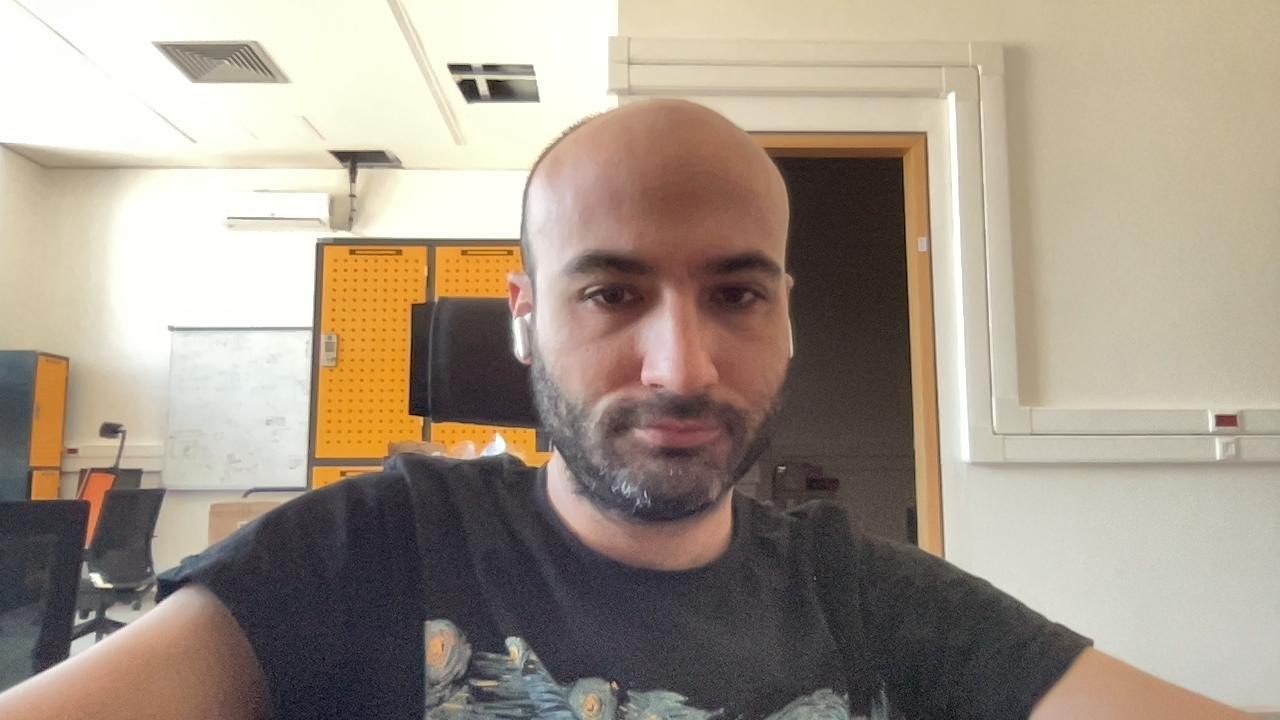

In [12]:
import cv2
import time 
import io
import numpy as np
from IPython.display import clear_output, Image, display
import PIL.Image as pil_im

def showarray(a, fmt='jpeg'):
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    pil_im.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

vc = cv2.VideoCapture(1)

try:
    while(True):
        rval, frame = vc.read()
        showarray(frame)
        time.sleep(0.1)
        clear_output(wait = True)
except KeyboardInterrupt:
    cv2.imwrite('out.jpg', frame)
    cv2.destroyWindow("preview")
    vc.release()

In [10]:
vc.release()

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pil_im
from PIL import ImageFont, ImageDraw, ImageEnhance, ImageFile
import cv2
# importing just because PIL refuses to read saved image
import  scipy.io
import gdown
import time 
import io

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.io import read_image

from ultralytics import YOLO

from IPython.display import display, Javascript
from base64 import b64decode
from IPython.display import clear_output, Image, display


# @title get image
class SquarePad:
    def __call__(self, image):
        s = image.shape
        max_wh = max(s[-1], s[-2])
        hp = int((max_wh - s[-1]) / 2)
        vp = int((max_wh - s[-2]) / 2)
        padding = (hp, hp, vp, vp)
        return F.pad(image, padding, 'constant', 0)

class norm_to_zo:
    def __call__(self, image):
        return image/255.0

class FeatureExtractorNet:
    def __init__(self, model_name='resnet18', device=torch.device('cpu')):
        self.model_name = model_name
        self.device = device
        self.model = self.get_model()

    def get_model(self):
        print(self.model_name)
        if self.model_name == 'resnet18':
            model_conv = models.resnet18(pretrained=True)
            print('resnet18 selected')
        if self.model_name == 'regnet_y':
            model_conv = models.regnet_y_16gf(pretrained = True)
        # Add more models as needed, e.g., elif self.model_name == 'resnet50': ...


        for param in model_conv.parameters():
            param.requires_grad = False

        model_feature = torch.nn.Sequential(*(list(model_conv.children())[:-1]))
        return model_feature.to(self.device)

    def extract_features(self, img):
        self.model.eval()
        transform = transforms.Compose([
            transforms.ToTensor(),
            SquarePad(),
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        img = transform(img)
        img = img.unsqueeze(0)
        img = img.to(self.device)
        with torch.no_grad():
            features = self.model(img)
        return features

class ObjectDetectorYOLO:
    def __init__(self, model_name='yolov5s'):
        self.model_name = model_name
        self.model = torch.hub.load('ultralytics/yolov5', self.model_name, pretrained=True)

    def detect_objects(self, image_path):
        results = self.model(image_path)
        return results.crop(save=False)

class ObjectSegmentorYOLO:
    def __init__(self, model_name='yolov8m-seg.pt'):
        self.model_name = model_name
        self.model = YOLO(self.model_name)
        self.yolo_classes = list(self.model.names.values())
        self.classes_ids = [self.yolo_classes.index(clas) for clas in self.yolo_classes]

    def detect_objects(self, image_path):
        results = self.model(image_path)
        return results[0]


class AffordanceAnalyzer:
    def __init__(self, model_name='resnet18', dataset_name='RGBDAffordance', img_size=224, device= 'cpu', nr_of_bases=20, auto_threshold = 0.8, plot_graph=False):
        self.model_name = model_name
        self.dataset_name = dataset_name
        self.img_size = img_size
        if device =='gpu':
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')
        #self.device = device
        self.nr_of_bases = nr_of_bases
        self.auto_threshold = auto_threshold
        self.plot_graph = plot_graph
        self.object_labels = ['ball', 'binder', 'bowl', 'calculator', 'camera','cap', 'cell_phone',
                'cereal_box', 'coffee_mug','comb', 'dry_battery', 'flashlight', 'food_bag',
                'food_box', 'food_can', 'food_cup', 'food_jar', 'glue_stick', 'hand_towel',
                'instant_noodles', 'keyboard','kleenex', 'lightbulb', 'marker', 'notebook',
                'pitcher', 'plate', 'pliers', 'rubber_eraser', 'scissors', 'shampoo',
                 'soda_can', 'sponge', 'stapler', 'toothbrush', 'toothpaste', 'water_bottle']
        self.affordance_names_T = ['Grasp', 'Wrap Grasp', 'Contain', 'Open', 'Tip-push', 'Display',
                    'Roll', 'Dry', 'Liquid contain', 'Pour', 'Grip', 'Absorb',
                    'Cut', 'Staple', 'Illuminate']
        self.affordance_names = ['grasp', 'wrap grasp', 'contain', 'open', 'tip-push', 'display',
                    'roll', 'dry', 'liquid_contain', 'pour', 'grip', 'absorb',
                    'cut', 'staple', 'illuminate']

        self.model_name_T = 'ResNet18' if model_name == 'resnet18' else 'RegNetY'
        w_matr =np.loadtxt(r'W_matr_%s.csv'%self.model_name, delimiter=',')
        w_max = np.max(w_matr)
        self.W_matr = torch.tensor(w_matr/w_max)

        self.base_list = dict()
        self.base_point_vecs = dict()
        self.state_dict = dict()
        self.threshold_dict = dict()
        self.afford_labellist = list()
        self.afford_dict = dict()
        self.afford_dict_T = dict()
        self.softmax = nn.Softmax()

    def take_photo(self, filename='photo.jpg'):
        def showarray(a, fmt='jpeg'):
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
            a = np.uint8(np.clip(a, 0, 255))
            f = io.BytesIO()
            pil_im.fromarray(a).save(f, fmt)
            display(Image(data=f.getvalue()))

        vc = cv2.VideoCapture(1)

        try:
            while(True):
                rval, frame = vc.read()
                showarray(frame)
                time.sleep(0.1)
                clear_output(wait = True)
        except KeyboardInterrupt:
            cv2.imwrite('out.jpg', frame)
            cv2.destroyWindow("preview")
            vc.release()



    def get_tens(self):
        # state vectors obtained from Resnet are loaded from previously saved file
        st_tns = torch.load(r'%s_with_%s_%dnetworkout.pt'%(self.model_name, self.dataset_name, self.img_size))
        st_tns = torch.transpose(st_tns, 0, 1)
        # also results of those tensor are loaded. Results contain affordance labels, like 0, 1, 2,
        rslt_tns = torch.load(r'%s_with_%s_%dlabel.pt'%(self.model_name, self.dataset_name, self.img_size))

        # image paths are loaded to name list
        # image names also contain names of the object/s in the image
        nm_list = []
        f = open(r'%s_with_%s_%dimagepaths.txt'%(self.model_name, self.dataset_name, self.img_size), 'r')
        for line in f:
            nm_list= line.strip().split('#')
        f.close()

        return st_tns, rslt_tns, nm_list

    def project_matr(self, bases):
        return torch.matmul(torch.matmul(bases, torch.linalg.inv(
            torch.matmul(torch.transpose(bases, 0, 1), bases) )), torch.transpose(bases, 0, 1))

    def matr_to_origin(self, tens, indx):
        [dim1, dim2] = tens.shape
        t = tens[:, indx]
        t = t.resize(dim1, 1).expand(dim1, dim2)
        return tens-t

    def matr_vec_to_origin(self, tens, vec):
        [dim1, dim2] = tens.shape
        vec = vec.resize(dim1, 1).expand(dim1, dim2)
        return tens-vec

    def matr_zero_mean(self, M):
        [dim1, dim2] = M.shape
        mn = torch.mean(M, 1)
        mn = mn.resize(dim1, 1).expand(dim1, dim2)
        return M-mn

    def calc_mi(self, m, ind,rdim, nnum):
        mto = self.matr_to_origin(m, ind)
        dig = torch.diag(torch.matmul(torch.transpose(mto, 0, 1), mto))
        salad, ind = torch.sort(dig)
        ind_e = ind[1:nnum+1]
        mi= self.matr_zero_mean(m[:, ind_e])
        u, s, vh = torch.linalg.svd(mi, full_matrices=True)
        return( torch.matmul(u[:,:rdim], torch.diag(s[:rdim])), s[:rdim], ind_e)

    def curv_calc(self, m, vct, rdim, nnum):
        mtp = self.matr_vec_to_origin(m, vct)
        dig = torch.diag(torch.matmul(torch.transpose(mtp, 0, 1), mtp))
        salad, ind = torch.sort(dig)
        ind_e = ind[0:nnum]
        #ind_w = ind[1:nnum]
        mn = m[:, ind_e]
        mni = self.matr_zero_mean(mn)
        #mw = m[:, ind_w]
        #mwi = self.matr_zero_mean(mw)
        mtot = torch.concat((mn, vct), 1)
        mtoti = self.matr_zero_mean(mtot)

        un, sn, vn = torch.linalg.svd(mni, full_matrices = True)
        utot, stot, vtot = torch.linalg.svd(mtoti, full_matrices = True)
        #uw, sw, vw = torch.linalg.svd(mwi, full_matrices = True)

        usn = torch.matmul(un[:,:rdim], torch.diag(sn[:rdim]))
        ustot = torch.matmul(utot[:,:rdim], torch.diag(stot[:rdim]))
        #usw = torch.matmul(uw[:,:rdim], torch.diag(sw[:rdim]))

        Q = torch.matmul(torch.transpose(usn, 0, 1), ustot)
        uq, sq, vq = torch.linalg.svd(Q)
        theta = torch.acos(torch.abs(torch.clamp(torch.sum(sq)/torch.sum(sn[:rdim]*stot[:rdim]), min=-1.0, max=1.0)))
        return theta#/theta_w

    def curv_calc_auto(self,m, vct):
        mtp = self.matr_vec_to_origin(m, vct)
        dig = torch.diag(torch.matmul(torch.transpose(mtp, 0, 1), mtp))
        salad, ind = torch.sort(dig)

        neighbour_number_list = list()
        neighbour_dim_list = list()

        for indx_num in range(2,100):
            #print(indx_num)
            ind_e = ind[0:indx_num]
            ind_w = ind[1:indx_num]
            mn = m[:, ind_e]
            mni = self.matr_zero_mean(mn)
            #mw = m[:, ind_w]
            #mwi = matr_zero_mean(mw)
            mtot = torch.concat((mn, vct), 1)
            mtoti = self.matr_zero_mean(mtot)

            un, sn, vn = torch.linalg.svd(mni, full_matrices = True)
            utot, stot, vtot = torch.linalg.svd(mtoti, full_matrices = True)
            #uw, sw, vw = torch.linalg.svd(mwi, full_matrices = True)
            #print(sn)

            energy_tensor = torch.cumsum(sn, dim = 0)/torch.sum(sn, dim = 0)
            #print(energy_tensor)
            #print(energy_tensor)
            try:
                rdim = torch.min((energy_tensor > self.auto_threshold).nonzero().squeeze()).item()
            except:
                rdim = 0
            neighbour_number_list.append(indx_num)
            neighbour_dim_list.append(rdim)
            if 3<=indx_num:
                if rdim<=neighbour_dim_list[-2]:
                    break
        usn = torch.matmul(un[:,:rdim], torch.diag(sn[:rdim]))
        ustot = torch.matmul(utot[:,:rdim], torch.diag(stot[:rdim]))
        Q = torch.matmul(torch.transpose(usn, 0, 1), ustot)
        uq, sq, vq = torch.linalg.svd(Q)
        theta = torch.acos(torch.abs(torch.clamp(torch.sum(sq)/torch.sum(sn[:rdim]*stot[:rdim]), min=-1.0, max=1.0)))
        return theta#/theta_w

    def optimal_thresh(self, prjct_matr, origin_zero, non_origin_zero):
        prjcts = torch.matmul(prjct_matr, origin_zero)
        non_prjcts = torch.matmul(prjct_matr, non_origin_zero)
        ratio_vls = torch.div(torch.norm(prjcts, dim = 0), torch.norm(origin_zero, dim = 0))
        non_ratio_vls = torch.div(torch.norm(non_prjcts, dim = 0), torch.norm(non_origin_zero, dim = 0))

        ref_range = 100
        true_pos_rat = []
        false_pos_rat = []
        ref_list = []
        opt_list = []

        for k in range(ref_range):
            ref_val = k/ref_range
            ref_list.append(ref_val)
            true_pos = torch.sum(ratio_vls>ref_val).item()
            false_neg = torch.sum(ratio_vls<=ref_val).item()

            true_neg = torch.sum(non_ratio_vls<=ref_val).item()
            false_pos = torch.sum(non_ratio_vls>ref_val).item()

            tpr = true_pos/(true_pos+false_neg)
            true_pos_rat.append(tpr)
            fpr = false_pos/(false_pos+true_neg)
            false_pos_rat.append(fpr)
            opt_list.append((fpr**2)+(1-tpr)**2)
            #print('tp, fn, tn, fp:',true_pos, false_neg, true_neg, false_pos)
        save_thresh = ref_list[opt_list.index(min(opt_list))]
        return(ratio_vls, non_ratio_vls, ref_list, opt_list, save_thresh, true_pos_rat, false_pos_rat)
    def get_subspace_bases(self):
        stat_tens, re_tens, nam_list = self.get_tens()
        state_tens = stat_tens[:,:8000]
        res_tens = re_tens[:8000,:]
        name_list = nam_list[:8000]

        #print(res_tens.shape)
        #taking transpose of the state tensor to make a column matrix
        # all results are looked up and affordance classes are listed
        self.afford_labellist = res_tens.unique().tolist()
        # '0' is removed since all results include it
        self.afford_labellist.remove(0)
        # defining affordance label value to name dictionary

        for i in range(len(self.afford_labellist)):
            self.afford_dict[self.afford_labellist[i]] = self.affordance_names[i]
            self.afford_dict_T[self.afford_labellist[i]] = self.affordance_names_T[i]

        non_base_point_vecs = dict()
        non_state_dict = dict()
        ratio_vals = dict()
        non_ratio_vals = dict()
        nr_of_bases_dict = dict()
        subs_angls = dict()


        red_dim = 3
        num_n = 10
        angl_list_tot = []
        if self.plot_graph:
            plt.figure()
        for i in self.afford_labellist:
            indices = torch.nonzero(torch.sum( (res_tens == i).int() , axis = 1))
            non_indices = torch.nonzero(torch.sum( (res_tens == i).int() , axis = 1)==0)
            afford_states = state_tens[:, indices.squeeze()].to(self.device)
            non_afford_states = state_tens[:, non_indices.squeeze()].to(self.device)
            self.state_dict[i] = afford_states

            mean_val = torch.mean(afford_states,1)
            non_mean_val = torch.mean(non_afford_states, 1).to(self.device)
            self.base_point_vecs[i] = mean_val.unsqueeze(1).to(self.device)
            [dim1, dim2] = afford_states.shape
            base_tens = mean_val.resize(dim1, 1).expand(dim1, dim2).to(self.device)
            origin_zero_matr = (afford_states-base_tens).to(self.device)
            U, S, Vh = torch.linalg.svd(origin_zero_matr, full_matrices = True)
            ratio_tens = torch.zeros(afford_states.shape)
            non_ratio_tens = torch.zeros(non_afford_states.shape)
            all_ratio_tens = torch.zeros(torch.cat((ratio_tens, non_ratio_tens), 1).shape)

            [dim1, dim2] = non_afford_states.shape
            non_base_origin = non_mean_val.resize(dim1, 1).expand(dim1, dim2).to(self.device)
            non_origin_tozero_matr = (non_afford_states-non_base_origin).to(self.device)


            ratio_tens = torch.abs(torch.div(torch.matmul(torch.transpose(U,0,1).to(self.device), origin_zero_matr), torch.norm(origin_zero_matr, dim = 0).unsqueeze(0).expand(origin_zero_matr.shape[0],-1)))
            non_ratio_tens = torch.abs(torch.div(torch.matmul(torch.transpose(U,0,1).to(self.device), non_origin_tozero_matr), torch.norm(non_origin_tozero_matr, dim = 0).unsqueeze(0).expand(non_origin_tozero_matr.shape[0],-1)))
            state_proj_mean = torch.mean(ratio_tens, 1)
            non_state_proj_mean = torch.mean(non_ratio_tens, 1)
            indc = torch.nonzero(state_proj_mean>non_state_proj_mean).squeeze().int()
            rtls, non_ratls, ref_list, opt_list, save_thresh, true_pos_rat, false_pos_rat = self.optimal_thresh(self.project_matr( U[:,indc]).to(self.device), origin_zero_matr, non_origin_tozero_matr)
            self.threshold_dict[i] = save_thresh
            self.base_list[i] =self.project_matr( U[:, indc]).to(self.device)
            if self.plot_graph:
                plt.plot(false_pos_rat, true_pos_rat, linewidth=3.0, label = self.afford_dict_T[i])
                plt.scatter(false_pos_rat[opt_list.index(min(opt_list))], true_pos_rat[opt_list.index(min(opt_list))], color = 'r', zorder =1000, s = 60)

        if self.plot_graph:
            plt.xlabel('False Positive Ratio')
            plt.ylabel('True Positive Ratio')
            plt.grid()
            #plt.legend()
            plt.title('ROC Curves of Affordance Groups for %s'%self.model_name_T)
            plt.savefig('ROC_Curve_%s.png'%self.model_name_T.replace("/", ""))
        return 0

    def load_models(self):
        print(self.model_name)
        self.featureExtractor = FeatureExtractorNet(model_name=self.model_name)
        self.objectDetector = ObjectDetectorYOLO()
        self.segmentator = ObjectSegmentorYOLO()

    def getWebcamPhoto(self, imagename='photo.jpg'):
        self.take_photo(imagename)

    def get_opt_result(self, scores, threshold_Val):
        score_dict = dict()
        scores_sorted, scores_indices = torch.sort(scores)
        w_ordered = [self.afford_dict[self.afford_labellist[x]] for x in scores_indices.tolist()]
        out_max = torch.max(scores)
        out_min = torch.min(scores)
        output_w = (scores - out_min*torch.ones_like(scores))/(out_max-out_min)
        outp, outi = torch.sort(output_w)
        range_tens = torch.range(0, len(self.afford_labellist)-1.0)/(len(self.afford_labellist)-1.0)
        out_optim = torch.square(range_tens-torch.ones_like(range_tens)) + torch.square(outp)
        optim_sorted, optim_ind_sorted = torch.sort(out_optim)
        if self.plot_graph:
            plt.figure()
            #plt.plot(range_tens.tolist(), outp.tolist(), linewidth=3.0)
            for k in range(optim_ind_sorted.shape[0]):
                #print('at position:',range_tens[k].item(), optim_sorted[k].item(), 'affordance ', self.afford_dict[self.afford_labellist[optim_ind_sorted[k]]])
                if k ==optim_ind_sorted[0]:
                    plt.text(range_tens[k].item()+0.02, outp[k].item(), self.afford_dict[self.afford_labellist[outi[k]]], color='red', rotation = 60)
                    plt.scatter(range_tens[k].item(), outp[k].item(), color='red', zorder =1000, s = 60)
                else:
                    plt.text(range_tens[k].item()+0.02, outp[k].item(), self.afford_dict[self.afford_labellist[outi[k]]], color='blue', rotation = 60)
                    plt.scatter(range_tens[k].item(), outp[k].item(), color='blue', zorder =1000, s = 60)
            plt.show()

        w_results = torch.nonzero(output_w >= outp[optim_ind_sorted[0]]).squeeze()
        mults = (output_w >= 1.2*outp[optim_ind_sorted[0]]).squeeze()*output_w.squeeze()
        mults[mults == 0] = -10e10
        mults = self.softmax(mults)
        score_dict['mult'] = mults
        score_dict['optim_result'] = [self.afford_dict[self.afford_labellist[k]] + ' %.3f'%mults[k] for k in w_results.tolist()]
        return score_dict


    def image_estimate(self, imagename='photo.jpg'):
        img = cv2.imread( imagename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pil_img = pil_im.fromarray(img)
        crops = self.objectDetector.detect_objects(pil_img)
        result_seg = self.segmentator.detect_objects(imagename)
        TINT_COLOR = (0, 0, 0)  # Black
        TRANSPARENCY = .35  # Degree of transparency, 0-100%
        OPACITY = int(255 * TRANSPARENCY)

        masks_seg = result_seg.masks.data
        boxes_seg = result_seg.boxes.data
        clss_seg = boxes_seg[:, 5]
        print('Segmented results are (YOLOv8):')
        for itr in range(len(clss_seg.tolist())):
            clss_num = clss_seg[itr]
            if self.segmentator.yolo_classes[int(clss_num.item())] == 'person':
                pass
            else:
                cls_indices = torch.where(clss_seg == clss_num)
                cls_masks = masks_seg[cls_indices]
                # scale for visualizing results
                cls_mask = torch.any(cls_masks, dim=0).int() * 255
                #cv2.imwrite('%s_segments.jpg'%yolo_classes[int(clss_num)], cls_mask.cpu().numpy())
                zeros_img = np.zeros_like(result_seg.orig_img)
                ids = np.where(cls_mask == 255)
                zeros_img[ids] = result_seg.orig_img[ids]
                pil_fa = pil_im.fromarray(zeros_img[:,:,::-1])
                x0, y0, x1, y1 = boxes_seg[itr, :4]
                width, height = pil_fa.size
                x0 = int(x0*0.9)
                y0 = int(y0*0.9)
                x1 = min(int(x1*1.1), width)
                y1 = min(int(y1*1.1), height)
                cropped = pil_fa.crop((x0, y0, x1, y1))
                crop_t = self.featureExtractor.extract_features(cropped)
                v1 = crop_t.squeeze(3).squeeze(0).to(self.device)
                print((v1-self.base_point_vecs[1]).shape)

                prjctns = torch.tensor([(torch.norm(torch.matmul(self.base_list[x], v1-self.base_point_vecs[x]))/torch.norm(v1-self.base_point_vecs[x])).item()-0.85*self.threshold_dict[x] for x in self.afford_labellist])
                prjctns = torch.abs(prjctns)
                prj_dict = self.get_opt_result(prjctns, 0.5)

                ang_la1 = [self.curv_calc(self.state_dict[k], v1, 3,20).item() for k in self.afford_labellist]
                la1_dict = self.get_opt_result(1/torch.tensor(ang_la1), 1.7)

                w_weighted = torch.matmul(self.W_matr.float(), la1_dict['mult'].unsqueeze(1))+ torch.matmul(self.W_matr.float(), prj_dict['mult'].unsqueeze(1))
                #output_w = m((1/w_weighted).squeeze())
                w_weighted = (1.0/w_weighted).squeeze()
                w_dict = self.get_opt_result(w_weighted, 0.000000000000000001)
                w_tot_results = w_dict['optim_result']
                if len(w_tot_results) == 0:
                    w_tot_results = ['found none']
                box_coords = boxes_seg[itr, :4].squeeze().tolist()
                cv2_img = cv2.imread( imagename)
                cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
                source_img = pil_im.fromarray(cv2_img).convert("RGBA")
                overlay = pil_im.new('RGBA', source_img.size, TINT_COLOR+(0,))
                draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
                draw.rectangle(((x0, y0), (x1, y1)), outline =(255, 0, 0), width = 5, fill=TINT_COLOR+(OPACITY,))
                print_string =  w_tot_results
                print_string = '\n'.join(print_string)
                draw.text((box_coords[0], box_coords[1]), 'YOLOv8 est is:' + self.segmentator.yolo_classes[int(clss_num.item())], font =ImageFont.truetype('LiberationMono-Bold.ttf',25),fill = (0, 0, 255, 255))
                draw.multiline_text((box_coords[0], box_coords[1]+20), print_string, font =ImageFont.truetype('LiberationMono-Bold.ttf',25),fill = (255, 255, 0, 255))
                source_img = pil_im.alpha_composite(source_img, overlay)
                source_img = source_img.convert("RGB") # Remove alpha for saving in jpg format.

                plt.imshow(cropped)
                plt.show()

                plt.imshow(source_img)
                plt.show()


        crops = self.objectDetector.detect_objects(pil_img)

        print('Non-Segmented Results are(YOLOv5):')

        for crop in crops:
            if 'person' in crop['label']:
                pass
            else:
                #since yolo sometimes crops the corners of the objects, lets make crop region 20% bigger
                x0, y0, x1, y1 = crop['box']
                width, height = pil_img.size
                x0 = int(x0*0.9)
                y0 = int(y0*0.9)
                x1 = min(int(x1*1.1), width)
                y1 = min(int(y1*1.1), height)
                cropped = pil_img.crop((x0, y0, x1, y1))
                #display(Image(crop))
                #crop_im = pil_im.fromarray(crop['im'][:,:,::-1])
                crop_t = self.featureExtractor.extract_features(cropped)
                v1 = crop_t.squeeze(3).squeeze(0).to(self.device)

                prjctns = torch.tensor([(torch.norm(torch.matmul(self.base_list[x], v1-self.base_point_vecs[x]))/torch.norm(v1-self.base_point_vecs[x])).item()-0.85*self.threshold_dict[x] for x in self.afford_labellist])
                prjctns = torch.abs(prjctns)
                prj_dict = self.get_opt_result(prjctns, 0.5)


                ang_la1 = [self.curv_calc(self.state_dict[k], v1, 3,20).item() for k in self.afford_labellist]
                la1_dict = self.get_opt_result(1/torch.tensor(ang_la1), 1.7)


                w_weighted = torch.matmul(self.W_matr.float(), la1_dict['mult'].unsqueeze(1))+ torch.matmul(self.W_matr.float(), prj_dict['mult'].unsqueeze(1))
                #output_w = m((1/w_weighted).squeeze())
                w_weighted = (1.0/w_weighted).squeeze()
                w_dict = self.get_opt_result(w_weighted, 0.000000000000000001)
                w_tot_results = w_dict['optim_result']
                if len(w_tot_results) == 0:
                    w_tot_results = ['found none']
                box_coords = [x.item() for x in crop['box']]
                cv2_img = cv2.imread( imagename)
                cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
                source_img = pil_im.fromarray(cv2_img).convert("RGBA")
                overlay = pil_im.new('RGBA', source_img.size, TINT_COLOR+(0,))
                draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
                draw.rectangle(((x0, y0), (x1, y1)), outline =(255, 0, 0), width = 5, fill=TINT_COLOR+(OPACITY,))
                print_string =  w_tot_results
                print_string = '\n'.join(print_string)
                draw.text((box_coords[0], box_coords[1]), 'YOLOv5 est is:'+ crop['label'], font =ImageFont.truetype('LiberationMono-Bold.ttf',25),fill = (0, 0, 255, 255))
                draw.multiline_text((box_coords[0], box_coords[1]+20), print_string, font =ImageFont.truetype('LiberationMono-Bold.ttf',25),fill = (255, 255, 0, 255))
                source_img = pil_im.alpha_composite(source_img, overlay)
                source_img = source_img.convert("RGB") # Remove alpha for saving in jpg format.

                plt.imshow(source_img)
                plt.show()


In [19]:
# @title Initialization
affordance_analyzer = AffordanceAnalyzer()#(device = 'cuda')
#aff_analyzer.download_files()
affordance_analyzer.load_models()
affordance_analyzer.get_subspace_bases()

resnet18
resnet18


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/ismail/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1108)>

If a webcam photo is desired to be analyzed for object affordances, please run below code to get an image using your webcam. First run may result in an error due to the web browser permissions. IN the second run, please allow browser to use webcam, then you can use capture button just above the webcam preview window that will be opened after running the code.

In [14]:
affordance_analyzer.take_photo()

NameError: name 'affordance_analyzer' is not defined

To analyze the image uploaded or captured by the webcam, please run the below code snipplet. If you are not using webcam, you can upload an image from your computer using the files section just right of the window. Then, uploaded image name should be passed as a string argument to image_estimate module, eg. aff_analyzr.image('uploaded_image.png'). Or, you can download an image from the web directly by uncommenting the !wget command. Then, you can get the image name from the right files panel.


image 1/1 /content/photo.jpg: 384x640 6 spoons, 1257.2ms
Speed: 4.2ms preprocess, 1257.2ms inference, 14.5ms postprocess per image at shape (1, 3, 384, 640)
Segmented results are (YOLOv8):
torch.Size([512, 1])


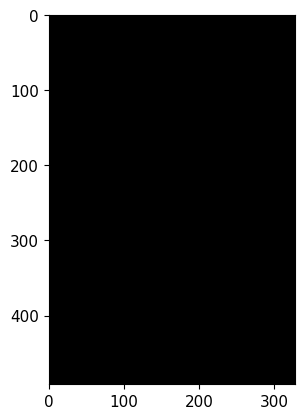

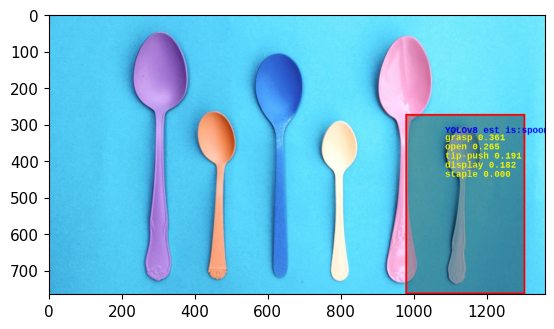

torch.Size([512, 1])


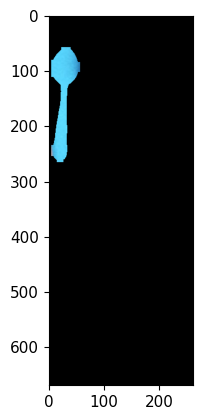

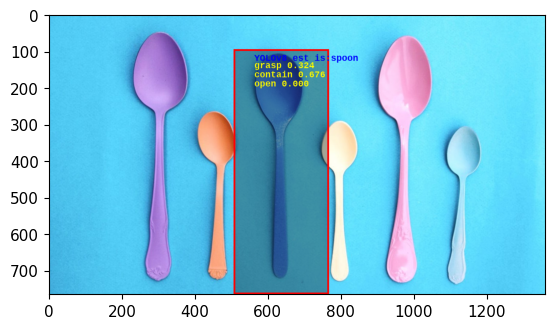

torch.Size([512, 1])


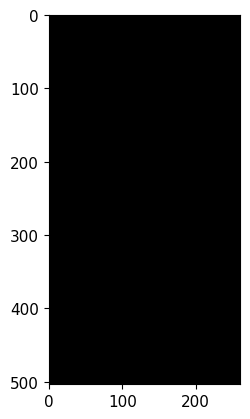

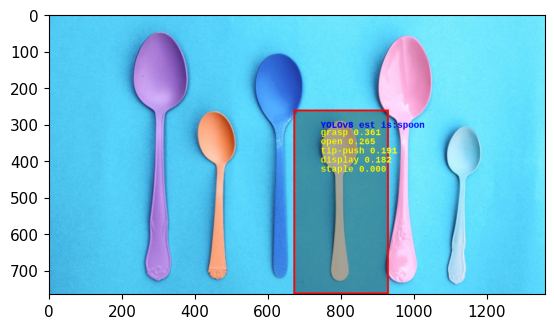

torch.Size([512, 1])


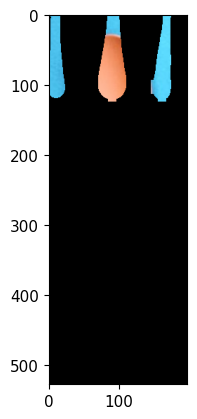

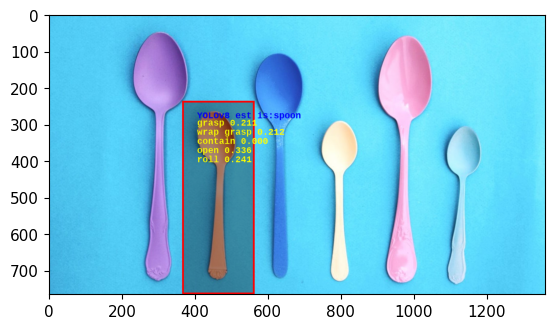

torch.Size([512, 1])


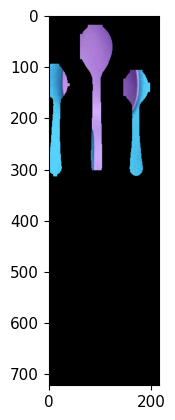

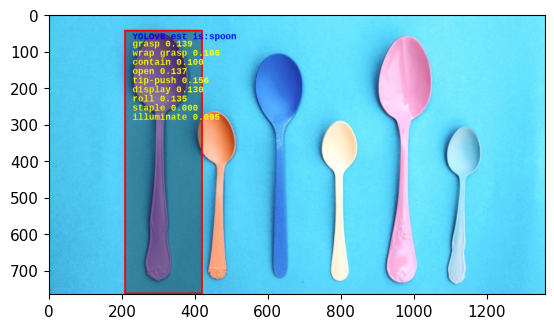

torch.Size([512, 1])


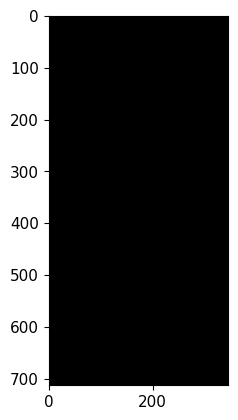

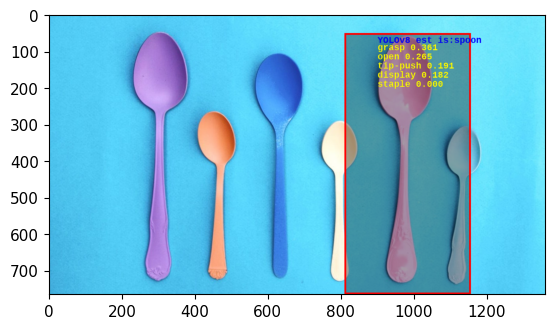

Non-Segmented Results are(YOLOv5):


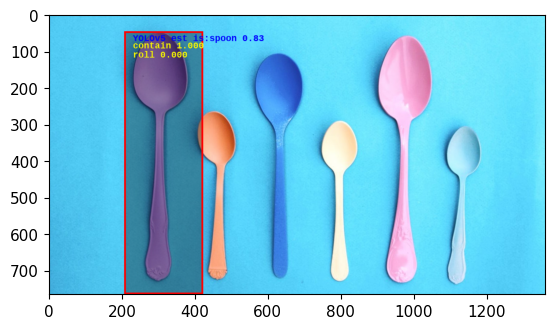

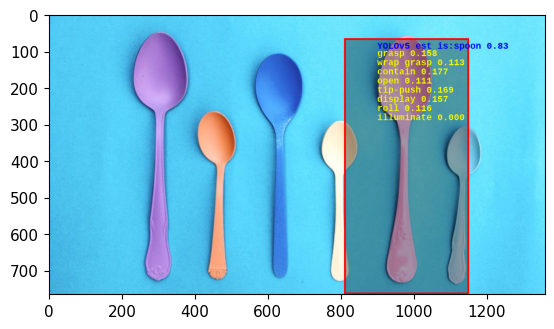

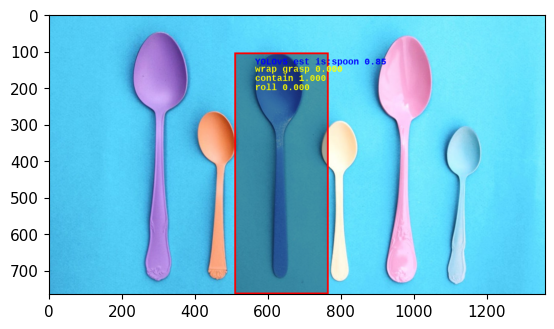

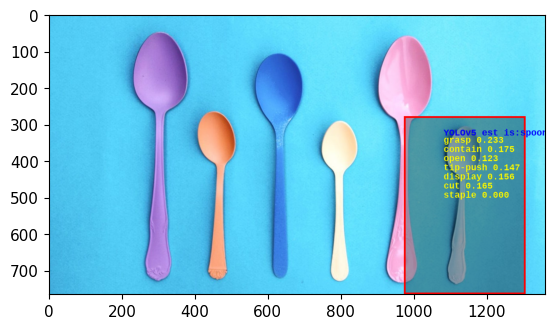

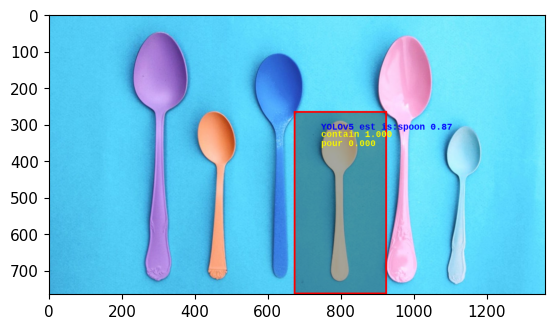

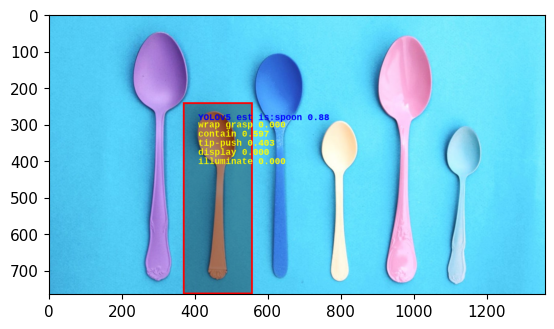

In [12]:
# @title Analyze Image
%matplotlib inline
#!wget -O image.jpg please_paste_link_to_image_here_if_image_from_web_is_desired
#!wget -O photo.jpg https://cdnimg.webstaurantstore.com/images/products/large/66832/2431635.jpg
affordance_analyzer.image_estimate()

#['grasp', 'wrap grasp', 'contain', 'open', 'tip-push', 'display',
#'roll', 'dry', 'liquid_contain', 'pour', 'grip', 'absorb',
#                    'cut', 'staple', 'illuminate']

In [12]:
print(affordance_analyzer.base_list[15].shape)
print(affordance_analyzer.base_point_vecs[1].shape)

torch.Size([3024, 3024])
torch.Size([3024])
